<H1>Stratégie Bollinger Trend Multicoin + Value at Risk</H1>
Indicateurs: bande de Bollinger + moyenne mobile long terme<br>
Gestion du risque via VaR<br>
SEG

In [11]:
# Modules standards
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import ccxt
# Modules perso
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month, complete_multi_asset_backtest
from backtest.multi_division.class_bol.boltrendmulti import BollingerTrendMulti
from utilities.data_manager import ExchangeDataManager

<H2>Coins + paramètres</H2>

In [75]:
# Liste des coins à backtester avec la stratégie.
# Chaque coin peut avoir un paramètre et un poids différent
wallet_exposure = 0.2
bb_window = 100
bb_std = 2.2
long_ma_window = 500

params_coin = {
    "BTC/USDT": {"wallet_exposure": 0.2, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ETH/USDT": {"wallet_exposure": 0.3, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    # Altcoins
    "AAVE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ADA/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "APE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ATOM/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "AVAX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "AXS/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "BCH/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "BNB/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    # "CAKE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "CHZ/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DOGE/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DOT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "DYDX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "EGLD/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "EOS/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "ETC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "FIL/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "GRT/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "LINK/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "LTC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "MATIC/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "MKR/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "NEAR/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "SAND/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "SHIB/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window },
    "SOL/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    "TRX/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
    # "VET/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},    
    "XRP/USDT": {"wallet_exposure": wallet_exposure, "bb_window": bb_window, "bb_std": bb_std, "long_ma_window": long_ma_window},
}

pair_list = list(params_coin.keys())
exchange_name = "binance"
tf = '1h'
oldest_pair = "BTC/USDT"

# Nouvelle méthode de chargement des données avec data_manager.py (plus besoin de passer par Javascript)
exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
# df_list[oldest_pair]

Data load 100%


<H2>Backtest</H2>

In [79]:
# Paramètres à modifier pour le backtest
initial_wallet = 1000
leverage = 1
max_var = 1.3
maker_fee, taker_fee = 0.00017, 0.00051   #Bitget
# maker_fee, taker_fee = 0.0003, 0.00012   #Binance

strat = BollingerTrendMulti(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    type=["long","short"]
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=initial_wallet, leverage=leverage, max_var=max_var, 
                               maker_fee=maker_fee, taker_fee=taker_fee)

# Sections à afficher ou pas pour le backtest complet
df_trades, df_days = complete_multi_asset_backtest(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

╒═════════════════════════════════╤══════════════════════════╕
│ Informations générales          │                          │
╞═════════════════════════════════╪══════════════════════════╡
│ Période                         │ 28.09.2017 -> 07.03.2023 │
│ Portefeuille initial            │ 1,000.00 $               │
│                                 │                          │
│ Portefeuille final              │ 4,880,413.89 $           │
│ Performance vs US dollar        │ 487,941.39 %             │
│ Pire Drawdown T|D               │ -25.97 % | -27.17 %      │
│ Moyenne journalière Drawdown    │ -8.14 %                  │
│ Buy and hold performance        │ 439.88 %                 │
│ Performance vs buy and hold     │ 90,298.15 %              │
│ Nombre total de trades          │ 1959                     │
│ Sharpe | Sortino | Calmar Ratio │ 2.53 | 4.9 | 6.64        │
│ Global Win rate                 │ 40.07 %                  │
│ Profit moyen                    │ 2.69 %             

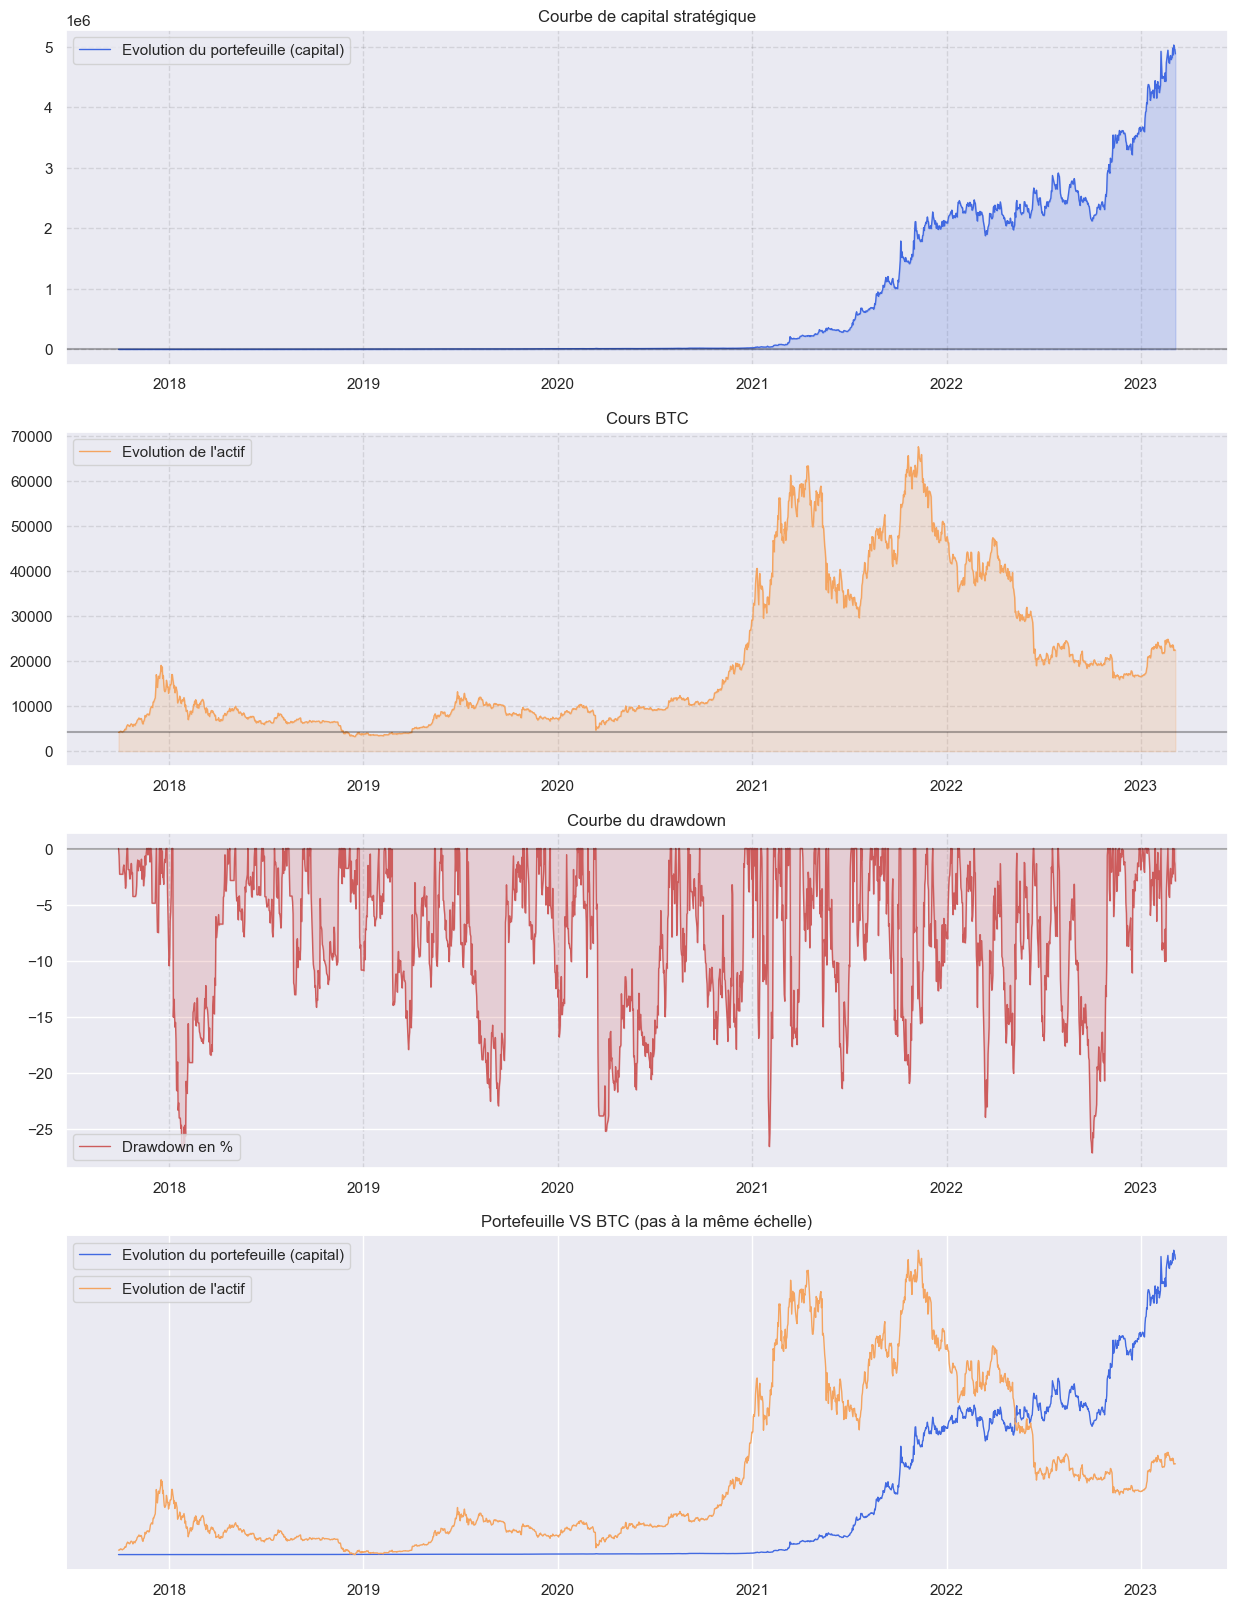

In [80]:
plot_wallet_vs_asset(df_days=df_days.loc[:], pair=oldest_pair)

<H2>Performance par mois et année</H2>

----- 2017 Performances cumulées: 26.29% --


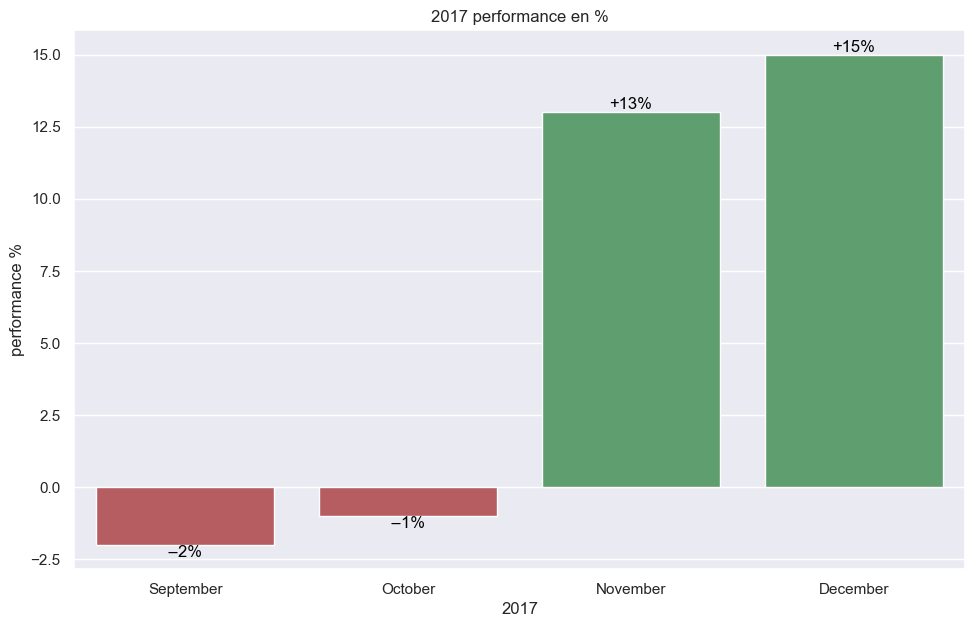

----- 2018 Performances cumulées: 260.58% --


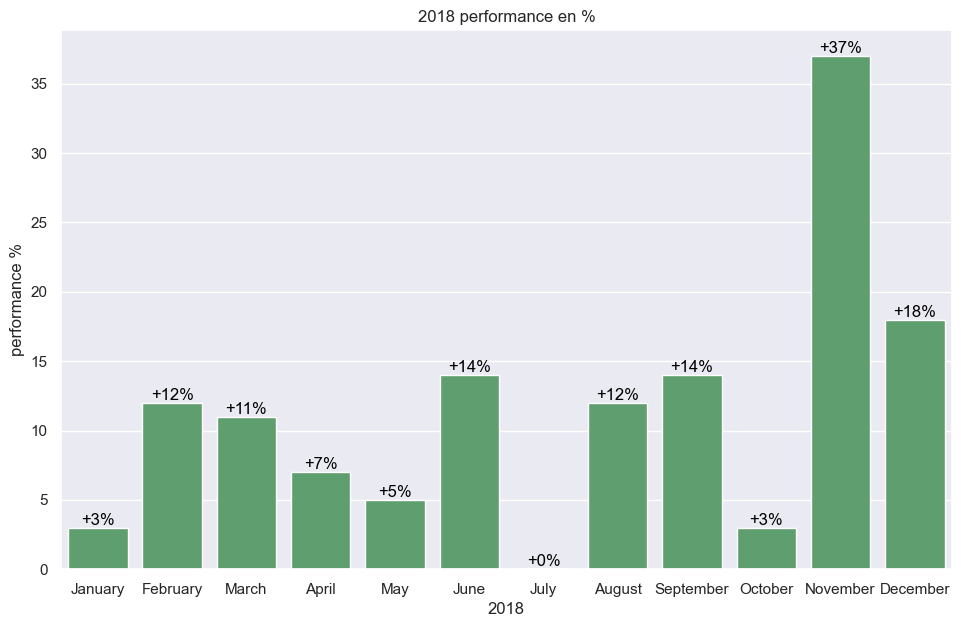

----- 2019 Performances cumulées: 109.93% --


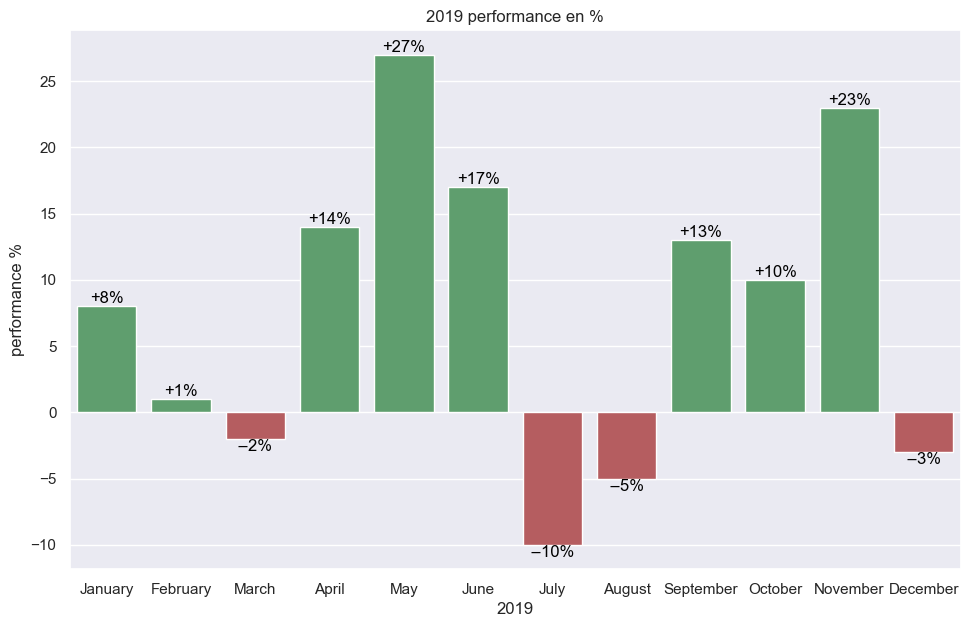

----- 2020 Performances cumulées: 168.11% --


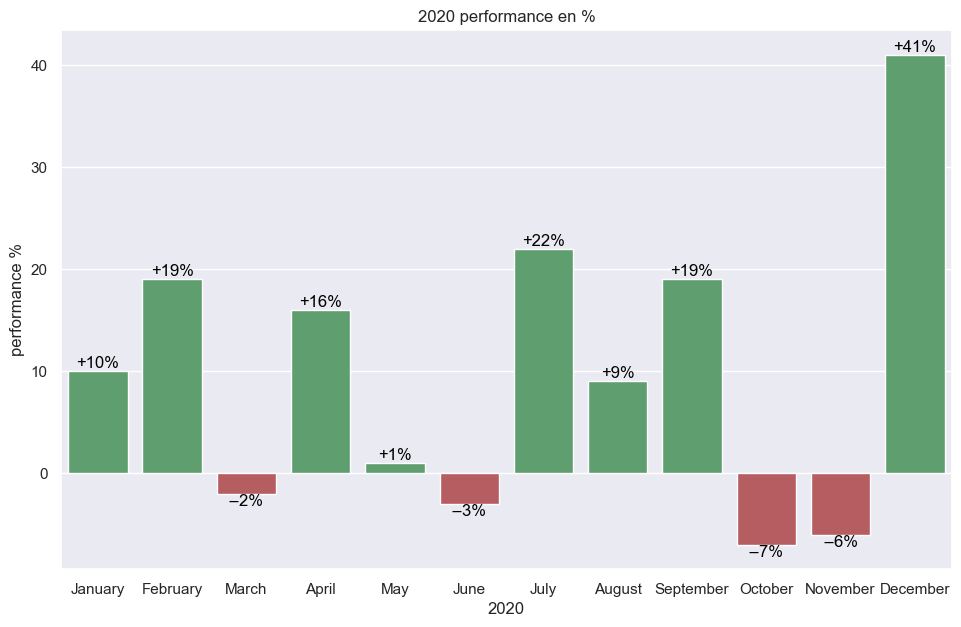

----- 2021 Performances cumulées: 7781.18% --


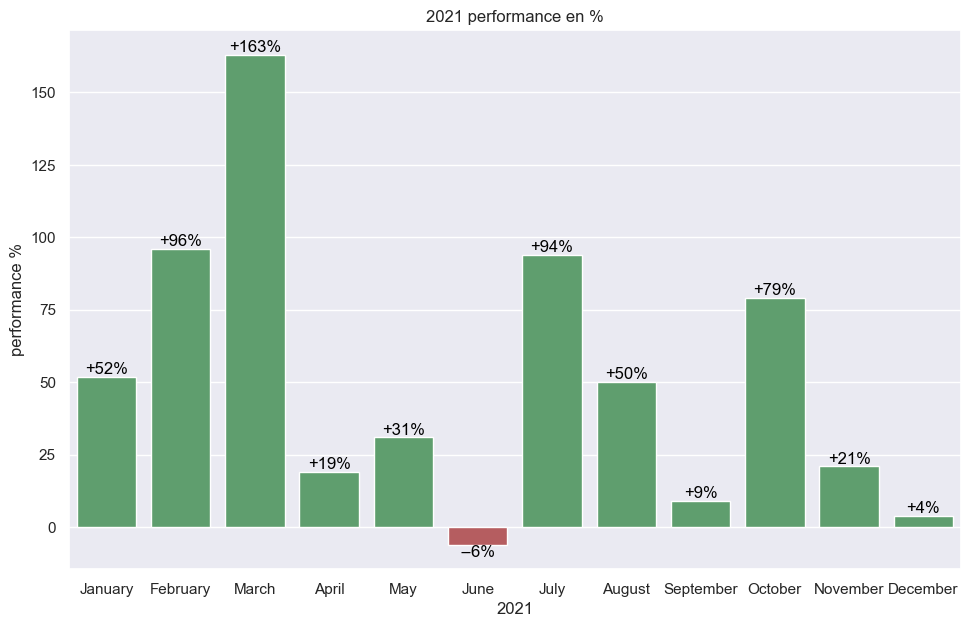

----- 2022 Performances cumulées: 75.81% --


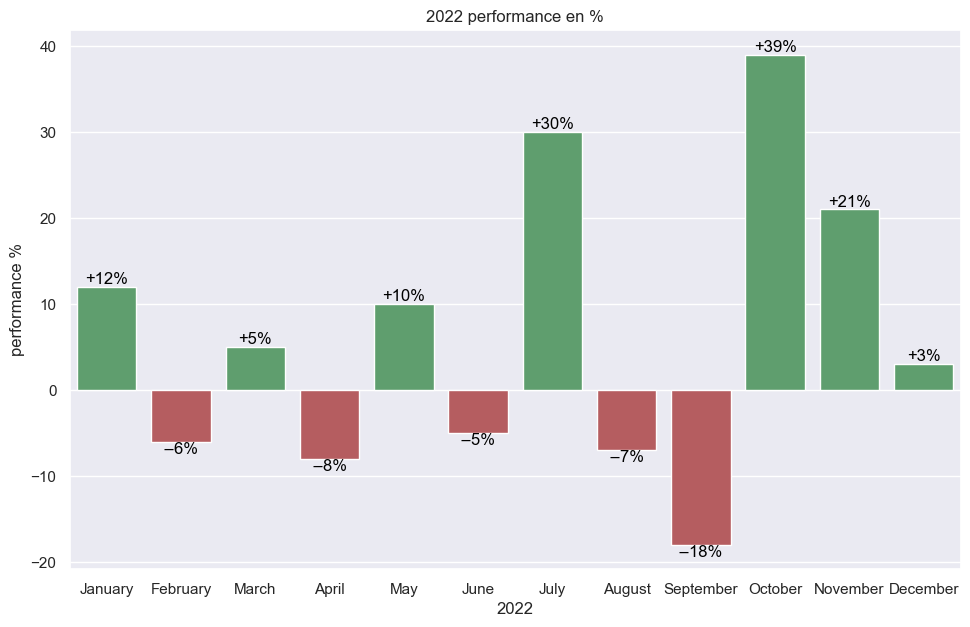

----- 2023 Performances cumulées: 35.58% --


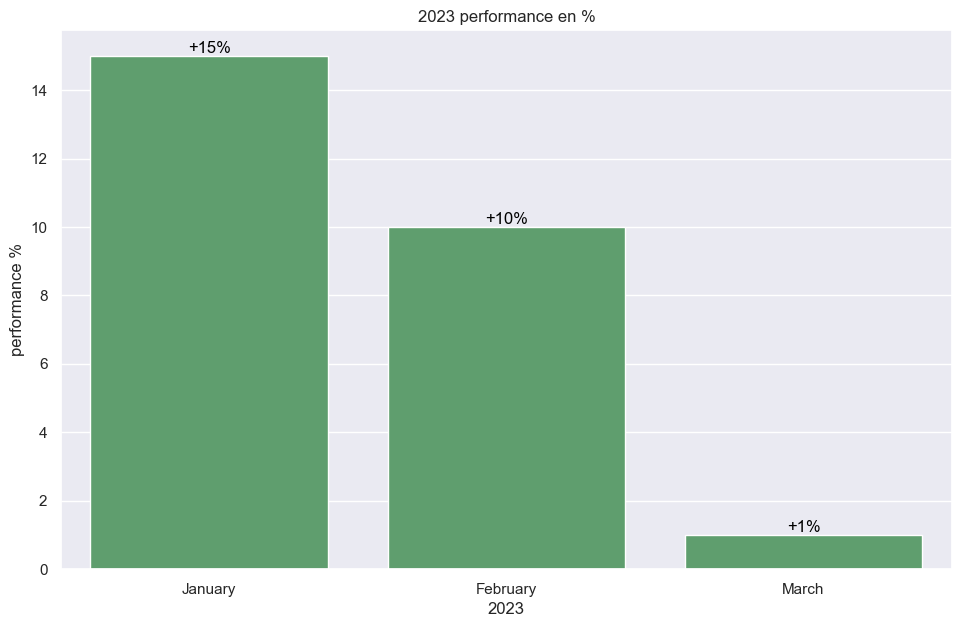

In [81]:
plot_bar_by_month(df_days=df_days.loc[:])

<H2>Courbe de surapprentissage</H2>

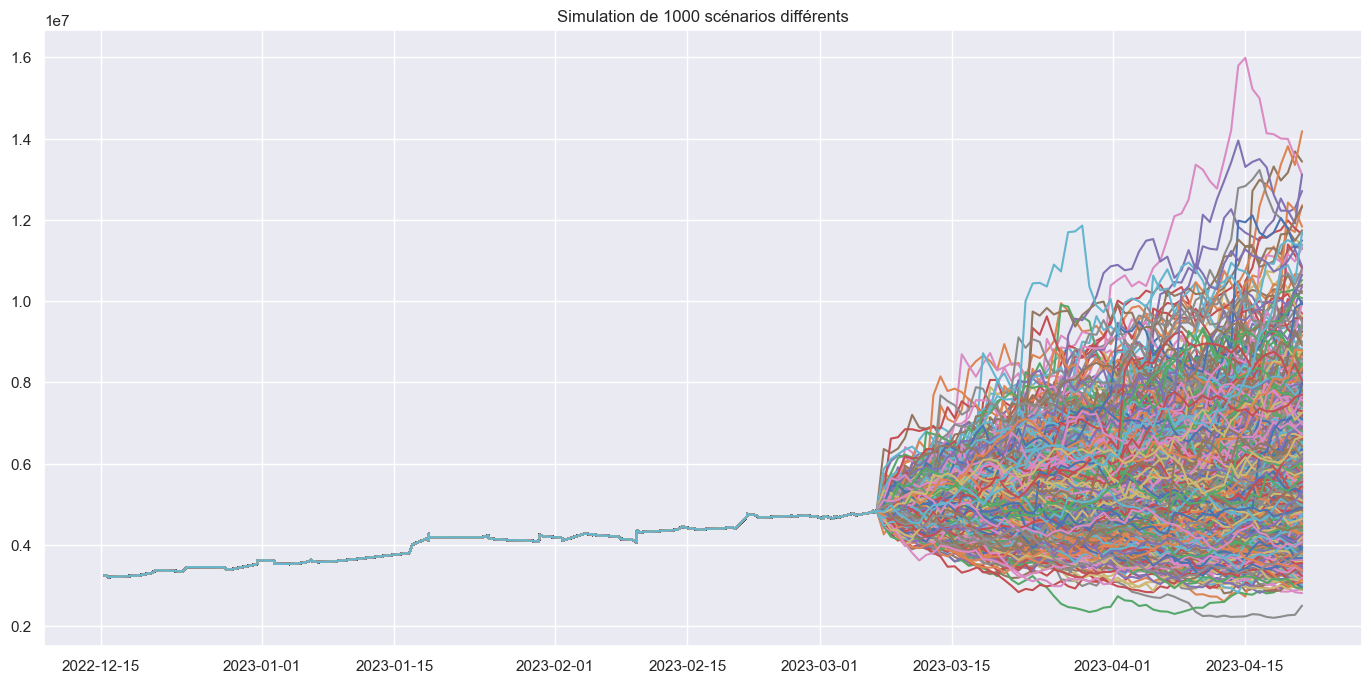

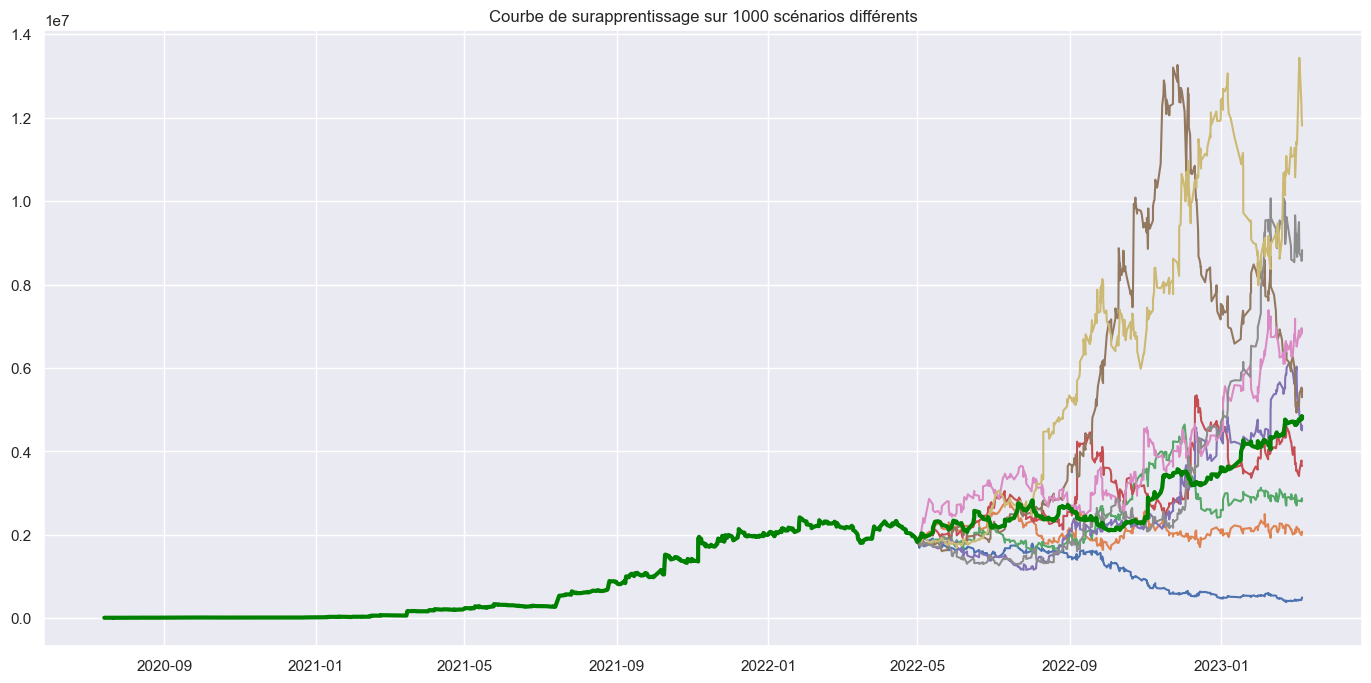

In [82]:
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=True
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
# Séparation des échantillons en train et en test - Méthode de Monte Carlo (Loi normale)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-05-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)